In [26]:
import datetime
import os

import requests
import pandas as pd
import matplotlib.pyplot as pl
import yaml
import numpy as np

In [3]:
with open(os.path.expanduser('~/.config/vigilant-crypto-snatch.yml')) as f:
    config = yaml.safe_load(f)
api_key = config['cryptocompare']['api_key']

In [4]:
timestamp = int(datetime.datetime.now().timestamp())
timestamp

1616249738

In [5]:
url = f'https://min-api.cryptocompare.com/data/histohour?api_key={api_key}&fsym=BTC&tsym=EUR&limit=2000&toTs={timestamp}'

In [6]:
r = requests.get(url)

In [7]:
r

<Response [200]>

In [30]:
data = r.json()['Data']
df = pd.DataFrame(data)
df['datetime'] = list(map(datetime.datetime.fromtimestamp, df['time']))

In [31]:
df

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,datetime
0,1609048800,22659.23,21970.89,21975.21,1817.48,40692787.44,22581.74,direct,,2020-12-27 07:00:00
1,1609052400,22680.31,22452.10,22581.74,1072.69,24216731.48,22588.76,direct,,2020-12-27 08:00:00
2,1609056000,22843.48,22377.87,22588.76,1983.46,44993542.12,22468.94,direct,,2020-12-27 09:00:00
3,1609059600,22754.38,22321.87,22468.94,1329.94,30020405.63,22741.71,direct,,2020-12-27 10:00:00
4,1609063200,22790.44,22648.87,22741.71,1014.26,23045329.41,22766.19,direct,,2020-12-27 11:00:00
...,...,...,...,...,...,...,...,...,...,...
1996,1616234400,49564.58,49352.23,49483.03,213.29,10545408.62,49394.21,direct,,2021-03-20 11:00:00
1997,1616238000,49836.89,49359.62,49394.21,344.81,17115707.94,49802.05,direct,,2021-03-20 12:00:00
1998,1616241600,49851.39,49443.01,49802.05,341.22,16948646.71,49764.77,direct,,2021-03-20 13:00:00
1999,1616245200,50203.07,49293.62,49764.77,1271.67,63456750.40,49626.71,direct,,2021-03-20 14:00:00


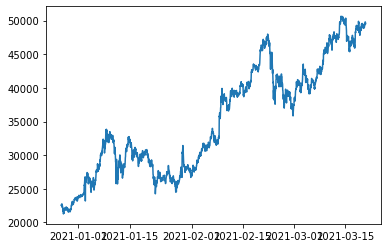

In [33]:
pl.clf()
pl.plot(df['datetime'], df['close'])
pl.
pl.show()

In [11]:
df['close'].shift()

0            NaN
1       22581.74
2       22588.76
3       22468.94
4       22741.71
          ...   
1996    49483.03
1997    49394.21
1998    49802.05
1999    49764.77
2000    49626.71
Name: close, Length: 2001, dtype: float64

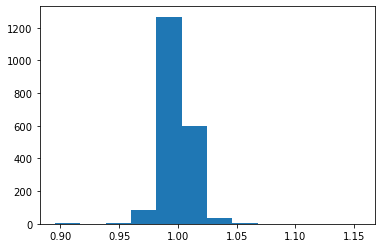

In [12]:
pl.clf()
pl.hist(df['close'].shift() / df['close'], bins='sturges')
pl.show()

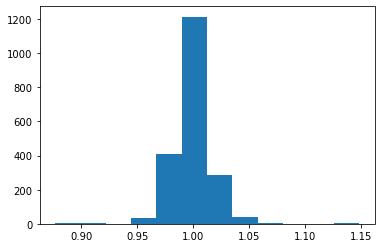

In [13]:
pl.clf()
pl.hist(df['close'].shift(2) / df['close'], bins='sturges')
pl.show()

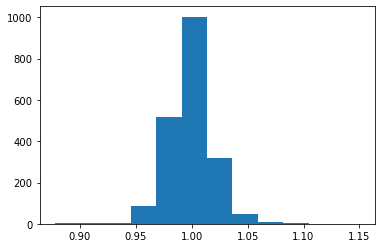

In [14]:
pl.clf()
pl.hist(df['close'].shift(3) / df['close'], bins='sturges')
pl.show()

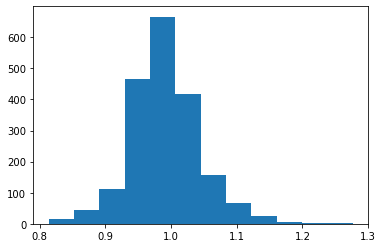

In [15]:
pl.clf()
pl.hist(df['close'].shift(24) / df['close'], bins='sturges')
pl.show()

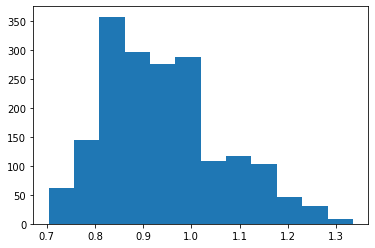

In [16]:
pl.clf()
pl.hist(df['close'].shift(7 * 24) / df['close'], bins='sturges')
pl.show()

In [17]:
def compute_gains(df: pd.DataFrame, hours: int, drop: float):
    close_shift = df['close'].shift(hours)
    ratio = df['close'] / close_shift
    
    btc = 0.0
    eur = 0.0

    last = -hours
    
    for i in range(len(df)):
        if ratio[i] < (1-drop) and last + hours <= i:
            last = i
            btc += 1.0 / df['close'][i]
            eur += 1.0
    return btc, eur, btc / eur if eur > 0 else 0.0

In [18]:
def compute_dca(df: pd.DataFrame, hours: int):    
    btc = 0.0
    eur = 0.0
    
    last = -hours
    
    for i in range(len(df)):
        if last + hours <= i:
            last = i
            btc += 1.0 / df['close'][i]
            eur += 1.0
    return btc, eur, btc / eur if eur > 0 else 0.0

In [19]:
compute_gains(df, 1, 0.05)

(0.00018338533396577644, 5.0, 3.667706679315529e-05)

In [20]:
compute_gains(df, 2, 0.05)

(0.00021539932193016136, 6.0, 3.5899886988360225e-05)

In [21]:
compute_dca(df, 1)

(0.06002080831882478, 2001.0, 2.99954064561843e-05)

In [22]:
compute_dca(df, 2)

(0.03002975001043276, 1001.0, 2.9999750260172587e-05)

In [23]:
hours = np.arange(1, 25)
drops = np.linspace(0.01, 0.25, 15)
factor = np.zeros(hours.shape + drops.shape)

In [24]:
for i, hour in enumerate(hours):
    for j, drop in enumerate(drops):
        factor[i, j] = compute_gains(df, hour, drop)[2]

<ipython-input-25-0dc9374620ff>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolormesh(hours, drops * 100, factor.T, cmap='turbo')


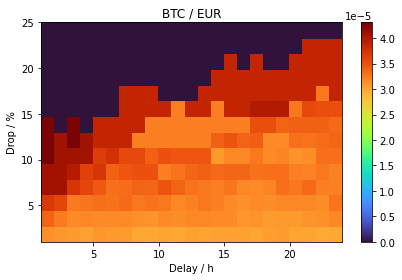

In [25]:
pl.clf()
pl.pcolormesh(hours, drops * 100, factor.T, cmap='turbo')
pl.colorbar()
pl.title('BTC / EUR')
pl.xlabel('Delay / h')
pl.ylabel('Drop / %')
pl.tight_layout()
pl.savefig('gains.pdf')
pl.show()